In [1]:
using Clustering, PyPlot
using TextAnalysis
using JLD2
using Statistics
using XLSX
using CSV
using DataFrames
using Dates
using LinearAlgebra
using StatsBase
using MultivariateStats
using Random

In [2]:
include("../src/utill.jl")

make_plots (generic function with 1 method)

In [3]:
new_df = XLSX.readxlsx("../data/Data-Spring/covid-ua.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_1 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang])
mask_tmp = ones(Bool, length(en_1.id_str)) 
insert!(en_1, 7, mask_tmp, :tind)


new_df = XLSX.readxlsx("../data/Data-Winter/covid-ua.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_2 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang]);

mask_tmp = zeros(Bool, length(en_2.id_str)) 
insert!(en_2, 7, mask_tmp, :tind)

min_dim = minimum([length(en_1.tind), length(en_2.tind)])

df = append!(en_1[1:min_dim, :], en_2[1:min_dim, :]);

# df = df[shuffle(1:length(df.favorite_count)), :]

## Preprocessing:

In [231]:
function preprocess_corp(data)
    data_preprocessed = replace.(data, r"http\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"\S+.com" => s"")
    data_preprocessed = replace.(data_preprocessed, r"resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RESULTING" => s"")
    data_preprocessed = replace.(data_preprocessed, r"#resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"@\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"&amp" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RT\S+" => s"");

    crps_tmp = Corpus(StringDocument.(deepcopy(data_preprocessed)));

    remove_case!(crps_tmp)
    prepare!(crps_tmp, strip_punctuation)
    prepare!(crps_tmp, strip_numbers)
    prepare!(crps_tmp, strip_articles)

    prepare!(crps_tmp, strip_pronouns)
    prepare!(crps_tmp, strip_prepositions)
    prepare!(crps_tmp, strip_definite_articles)
    prepare!(crps_tmp, strip_indefinite_articles)

#     prepare!(crps_tmp, strip_stopwords)
    remove_words!(crps_tmp, ["covid", "коронавирус", "coronavirus", "коронавируса", "коронавирусом", "коронавірус", 
            "ковід", "ukraine", "україні", "випадків", "нових", "published", "виявили", "новини", "через", "кількість", "області",
            "понад", "станом", "квітня", "проти", "коронавірусу", "випадки", "зафіксовано", "грудня", "грудня", 
            "україни", "україна", "минулу", "укрінформ", "новости", "уніан", "після", "газета", "більше", "тисяч", "майже", "випадок", "новий", "коронавірусом"])
#     stem!(crps_tmp)
    prepare!(crps_tmp, strip_whitespace)
    update_lexicon!(crps_tmp)
    return crps_tmp
end

preprocess_corp (generic function with 1 method)

In [232]:
crps = preprocess_corp(df[:,4])

A Corpus with 5122 documents:
 * 5122 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 12127 tokens
Corpus's index contains 0 tokens

In [233]:
# crps_1 = preprocess_corp(df[df.tind,4])
# crps_2 = preprocess_corp(df[.!df.tind,4]);

In [234]:
# Create a vector from merged corpus: 

lexicone_vect = lexicon(crps)

n_max = 300
pairs = sort(collect(lexicone_vect), by=x->x[2], rev=true)[1:n_max]
terms = [i[1] for i in pairs]

terms_mask = [length(term)>4 for term in terms]
terms = terms[terms_mask];

In [235]:
terms[1:25]

25-element Array{String,1}:
 "хворих"
 "людей"
 "захворювання"
 "вакцини"
 "одужали"
 "захворіли"
 "хвороби"
 "коронавірусної"
 "підтвердили"
 "карантин"
 "пацієнтів"
 "зафіксували"
 "вакцину"
 "києві"
 "пандемії"
 "померли"
 "степанов"
 "медиків"
 "українська"
 "відео"
 "підтверджено"
 "поширення"
 "статистика"
 "здоровя"
 "світі"

In [236]:
m = DocumentTermMatrix(crps, terms)

A 5122 X 190 DocumentTermMatrix

In [237]:
D = convert.(Float64, dtm(m, :dense)')

# D[:,df.tind] = D[:,df.tind] ./ sum(D[:,df.tind])
# D[:,.!df.tind] = D[:,.!df.tind] ./ sum(D[:,.!df.tind]);

In [238]:
# PCA:

M = fit(PCA, D; maxoutdim=5)
Yte = MultivariateStats.transform(M, D)

5×5122 Array{Float64,2}:
  0.029922   -0.0860788  -0.061822   0.0505265  …  -0.0617727   -0.0767228
 -0.0244596  -0.0579034   0.520071   0.229391      -0.0929198   -0.099471
 -0.0253134   0.0954031  -1.03379   -0.0696404      0.024661     4.48683e-5
  0.0189836   0.0383591   1.32399    0.311378       0.00853052  -0.00984664
  0.0506399   0.0501693  -0.457581  -0.0390379      0.0551727    0.0535328

In [239]:
# Independent Component Analysis:

# M = fit(ICA, D, 6)
# Yte = MultivariateStats.transform(M, D)

In [240]:
n_clusters = 4

cl = kmeans(Yte, n_clusters);

cl_assignments = cl.assignments;

In [241]:
vars = (Yte, cl_assignments, M, D)
JLD2.@save "../data/tmp_files/ua.jld" vars

In [242]:
# JLD2.@load "../data/tmp_files/de.jld" vars
# (Yte, cl_assignments, M, D) = vars ;

In [243]:
cvals= log.(1 .+ df.favorite_count)
avals = 1 .+ df.retweet_count ; avals = log.(avals); avals = avals .- (minimum(avals) - 0.1) ; avals = avals ./ maximum(avals)
avals_t = [df.tind[i] == 1 ? plt.cm.Blues_r(avals[i]) : plt.cm.Reds_r(avals[i]) for i in eachindex(df.tind)];

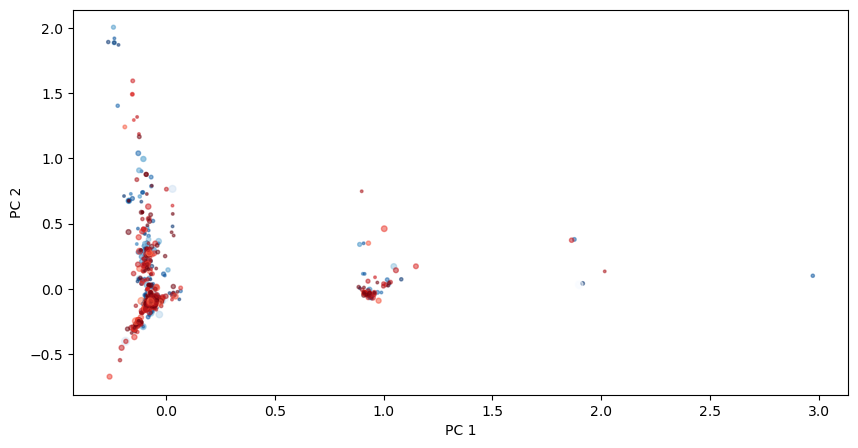

In [244]:
fig, ax= plt.subplots(1,1, figsize=(10,5))

ax.scatter(Yte[1,:], Yte[2,:], alpha=0.5, s=5.0.*cvals, c=avals_t, rasterized=true, label="April")

# ax.set_xlim(-1, 7)
# ax.set_ylim(-1, 7)

# ax.legend(loc="lower right", frameon=false ) # 

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# ax.set_xticks([])
# ax.set_yticks([]);

# ax.set_xticklabels([])
# ax.set_yticklabels([]);

# ax.set_axis_off()

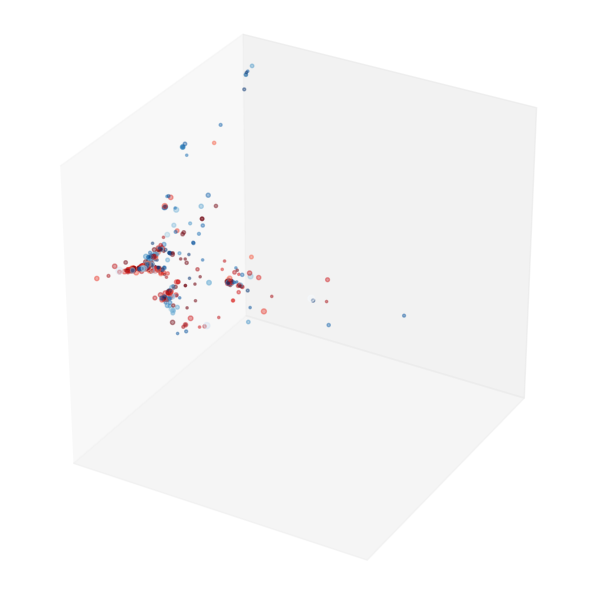

In [245]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection="3d")

ax.scatter(Yte[1,:], Yte[2,:], Yte[3,:],  alpha=0.4, s=4.0.*cvals, c=avals_t, rasterized=true, label="April") 

# ax.set_xlabel("PC 1")
# ax.set_ylabel("PC 2")
# ax.set_zlabel("PC 3")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([]);

# ax.set_xlim(0.2, 7)
# ax.set_ylim(-0, 7)
# ax.set_zlim(-3.5, 0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# ax.w_xaxis.gridlines.set_lw(0.5)
# ax.w_yaxis.gridlines.set_lw(0.5)
# ax.w_zaxis.gridlines.set_lw(0.5)

# ax.view_init(elev=10.,) # azim=-10

ax.set_box_aspect((1, 1, 1))
# ax.set_axis_off()

fig.tight_layout()

# fig.savefig("../plots/3d-samples-de.pdf", bbox_inches = "tight", dpi=800)

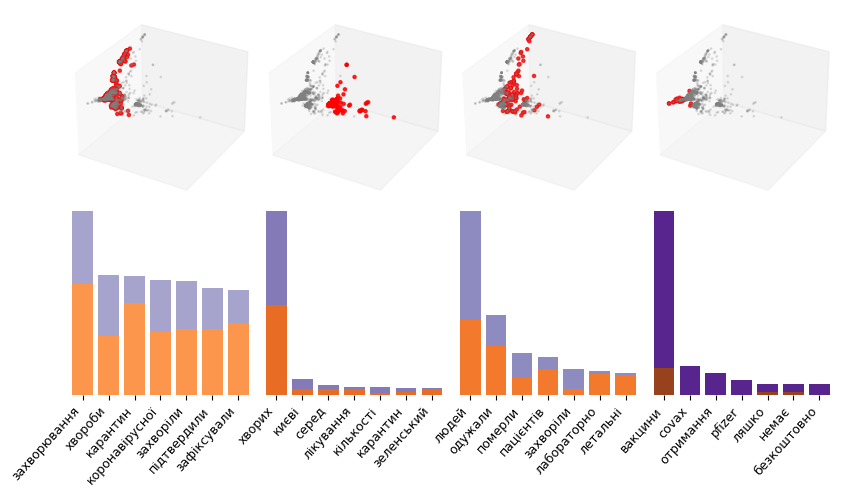

In [246]:
# Oranges - Begining 
# Purples - End

figure = make_plots(Yte, D, terms, cl_assignments, df.tind, df.retweet_count, ); #size=(15,15)

In [247]:
# figure.savefig("../plots/words-clusters-ua.pdf", bbox_inches = "tight")